# Data generation

In this notebook we are going to combine several Inside Airbnb datasets to generate a big dataset containing the joint information. We assume they all have been gathering the same information (columns). Once we have the data together, we will look for outliers using visualization.

In [1]:
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
import pickle
from currency_converter import CurrencyConverter
%matplotlib inline

In [6]:
# Read seattle Kaggle info
ratings = pd.read_csv('../data/seattle/reviews.csv')
listings = pd.read_csv('../data/seattle/listings.csv')
calendar = pd.read_csv('../data/seattle/calendar.csv')
curr_conv = CurrencyConverter() # Used for parsing prices

## Data overview

Visualize Seattle data by taking a look at each read DataFrame.

In [366]:
ratings.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

In [81]:
listings.head(n=2)

id                          listing_url       scrape_id last_scraped  \
0  241032  https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1  953595  https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   

                                 name  \
0        Stylish Queen Anne Apartment   
1  Bright & Airy Queen Anne Apartment   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   

             ...             Laptop Friendly Workspace Dryer Dog(s)  \
0            ...                                 False  True  False   
1            ...                                 False  True  False   

  Elevator in Building Other pet(s) Cable TV  Breakfast  \
0                False        False     True      False   
1                False        False    False      False   

  Free Parking on Premises    Gym Pets live on this property  
0                    False  False                      False  
1                     True  False                      False  

[2 rows x 135 columns]

In [370]:
calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

## Data cleaning

Some preprocessing must be done before getting the columns of interest. First of all, let's convert the scrapping time into a datetime format

### Formatting dates

Design function to format dates into Python supported format.

In [1]:
def to_date(x):
    return datetime.strptime(x, '%Y-%m-%d')

## Missing values

Let's take a first glance at the missing values on those columns of interest. Let's check that their missing values stay less than 15% of the total. However, in some columns it must be allowed since missing values have a special meaning (e.g. scores, fees).

In [9]:
def check_missings(data):
    """ Returns the name and ratio of missing for those columns containing
    any missing information """
    missings = []
    for i in data.columns:
        nulls = data[i].isnull()
        if nulls.any():
            missings.append((i, sum(nulls)/float(data.shape[0])))
    return missings

def print_missing_cols(data):
    miss_cols = check_missings(data)
    for (name, ratio) in miss_cols:
        print('Column %s has %f ratio of missings' % (name, ratio))

col_subset = ['accommodates', 'amenities', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'cancellation_policy',
              'city', 'cleaning_fee', 'country_code', 'extra_people', 'price', 'guests_included',
              'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_verifications',
              'id', 'instant_bookable', 'last_review', 'picture_url', 'minimum_nights',
              'neighbourhood_group_cleansed', 'number_of_reviews', 'property_type', 'review_scores_accuracy',
              'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 
              'review_scores_location', 'review_scores_rating', 'review_scores_value', 'room_type',
              'last_scraped', 'security_deposit', 'state']

# Print those above 10%
listings = listings[col_subset]
missing = [(name, ratio) for (name, ratio) in check_missings(listings) if ratio > 0.10]
for (name, ratio) in missing:
    print('Column %s has missing ratio %f' % (name, ratio))

Column cleaning_fee has missing ratio 0.269775
Column last_review has missing ratio 0.164222
Column review_scores_accuracy has missing ratio 0.172342
Column review_scores_checkin has missing ratio 0.172342
Column review_scores_cleanliness has missing ratio 0.171032
Column review_scores_communication has missing ratio 0.170508
Column review_scores_location has missing ratio 0.171556
Column review_scores_rating has missing ratio 0.169460
Column review_scores_value has missing ratio 0.171818
Column security_deposit has missing ratio 0.511262


We observe that some columns have negligible missing instances (e.g. property_type) that can be deleted later. Other fields will be further fixed (e.g. reviews, bathrooms) and some othes have substantial number of missing values (e.g. square_feet)

### Pricing

Now let's focus on the lodging price. As we can see, it is not converted into a numerical column but contains the symbol of the currency used. Calendar DataFrame contains the evolution of the price of the apartment through the year but only on those days it was available while Listings DataFrame contains the price at the time of the last scrapping. We decide to use the mean price through the tracked period when it is available and use the scrapped one when it is not.

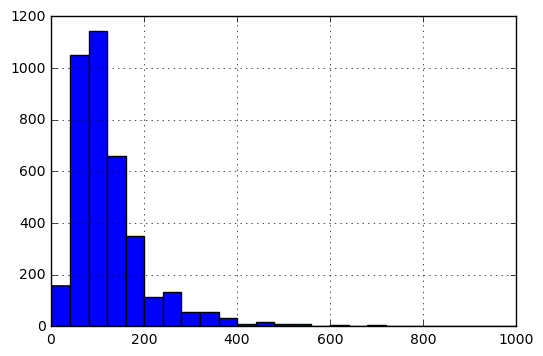

In [10]:
def parse_amount(x):
    """ Parse string formatted prince into numeric """
    found = re.search('(\d+(\.\d+)?)', x).groups()
    if len(found) == 0:
        raise ValueError('No price found for %s' % x)
    else:
        return float(found[0])
        
def parse_price(x, parsed_time):
    """ Parse price into dollars (numeric) """
    if type(x) == float:
        return x
    else:
        x = x.strip() # Eliminate possible blankspaces at end and beggining
        if x[0] == '$': # $
            return parse_amount(x)
        elif x[0] == u"\xA3": # £
            return curr_conv.convert(parse_amount(x), 'GBP', 'USD', date=parsed_time)
        elif x[0] == u"\u20ac": # €
            return curr_conv.convert(parse_amount(x), 'EUR', 'USD', date=parsed_time)
        else:
            raise ValueError('Unkown currency %s' % x[0])

def get_price(mean_price, default_price):
    """ Returns the price of the lodgning as the mean anual price. 
    If no anual price available, we get the default price in the listings """
    if np.isnan(mean_price):
        return default_price
    else:
        return mean_price

SCRAPED = True # Whether to use scraped price (True) or the mean of the calendar when available (False)

# Convert dates involved into proper format        
listings['last_scraped'] = listings['last_scraped'].apply(to_date)
calendar['date'] = calendar['date'].apply(to_date)

# Convert prices to dollars
listings['price'] = listings.apply(lambda x: parse_price(x['price'], x['last_scraped']), axis=1)
calendar['price'] = calendar.apply(lambda x: parse_price(x['price'], x['date']), axis=1)

if SCRAPED is True:
    listings['final_price'] = listings['price']
else:
    # Compute mean price during period
    mean_price_year = calendar.groupby('listing_id').mean().reset_index()
    merged = pd.merge(mean_price_year, listings, left_on=['listing_id'], right_on=['id'])
    # Get price as the average if available. Otherwise get the scraped one
    merged['final_price'] = merged.apply(lambda x: get_price(x['price_x'], x['price_y']), axis=1)
    merged = merged[['final_price', 'listing_id']]
    # Merge final price into the listings
    listings = pd.merge(listings, merged, left_on=['id'], right_on=['listing_id'])

# Display prices
listings['final_price'].hist(bins=25)

### Score handling

Some scores are empty due to apartments not being rated by any users. These data must not be missed but 

In [11]:
# Categorization of scores

def to_categorical(score, lowerb, upperb):
    """ Converts score into category considering the input bounds
        Categories defined as: 
        
            - 95% and above is good. 
            - 90%-95% is normal
            - below 90% is bad.
            - Missing is non-rated
        
        People use to rate high in Airbnb, so we decide to set high thresholds
    """
    if np.isnan(score):
        return "non-rated"
    else:
        val_rang = float(upperb - lowerb)
        ratio = score/val_rang
        if ratio >= 0.95:
            return "good"
        elif ratio >= 0.90 and ratio < 0.95:
            return "normal"
        elif ratio < 0.90:
            return "bad"

def categorize_score(df, name, lowerb, upperb):
    """ Converts into categorical the input column and checks value are in given interval """
    # Check values are correct
    min_val, max_val = df[name].min(), df[name].max()
    if min_val < lowerb or max_val > upperb:
        raise ValueError('Values in column are out of the specified interval [%f,%f]'
                        % (lowerb, upperb))
    return df[name].apply(lambda x: to_categorical(x, lowerb, upperb))


# Convert subratings
review_10_scores = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value']
for c in review_10_scores:
    listings.loc[:, c] = categorize_score(listings, c, 0.0, 10.0)

# Convert general rating
listings.loc[:, 'review_scores_rating'] = categorize_score(listings, 'review_scores_rating', 0.0, 100.0)

### Amenities

Let's get the list of amenities and convert them into dummy variables

In [12]:
def parse_amenities(x):
    """ Parses amenities string format into a set """
    
    if x[0] == '{':
        x = x[1:]
    if x[-1] == '}':
        x = x[:-1]
    
    def parse_elem(elem):
        """ Parses each element between colons """
        if elem[0] == '"':
            elem = elem[1:]
        if elem[-1] == '"':
            elem = elem[:-1]
        return elem

    if not x:
        # Empty list
        return []
    else:
        return set([parse_elem(elem) for elem in x.split(",")])

def get_amenity_bool(am_list, am):
    """ Whether the input amenity is included in the input amenity list """
    return am in parse_amenities(am_list)

    
# Get set of amenities
amenities = set()
to_erase = []
for index, row in listings.iterrows():
    # Parse amenities for current row
    current_amenities = parse_amenities(row['amenities'])
    amenities = amenities.union(current_amenities)
    
    # If no amenity found, append to erase it
    if len(current_amenities) == 0:
        to_erase.append(index)

# Erase those which have no amenities (all lodgings should have at least one)
print('Erasing %d rows' % len(to_erase))
listings = listings.drop(to_erase)
        
# Save amenities into pickle
with open('amenities.dat', 'w') as f:
    pickle.dump(amenities, f)
        
# Let's create a dummy variable for each amenity
for a in amenities:
    listings[a] = listings['amenities'].apply(lambda x: get_amenity_bool(x, a))

# Let's visualize the amenities
for am in amenities:
    am_stats = listings.groupby(am).count()['id']
    falses, trues = am_stats[0], am_stats[1]
    print('Amenity "{}": True({}), False({})'.format(am, trues, falses))

Erasing 45 rows
Amenity "Essentials": True(3237), False(536)
Amenity "Wireless Internet": True(3667), False(106)
Amenity "Washer / Dryer": True(2), False(3771)
Amenity "Suitable for Events": True(209), False(3564)
Amenity "Internet": True(2811), False(962)
Amenity "Washer": True(2992), False(781)
Amenity "Hangers": True(846), False(2927)
Amenity "Air Conditioning": True(677), False(3096)
Amenity "Wheelchair Accessible": True(300), False(3473)
Amenity "Smoke Detector": True(3281), False(492)
Amenity "Buzzer/Wireless Intercom": True(538), False(3235)
Amenity "TV": True(2574), False(1199)
Amenity "Smoking Allowed": True(82), False(3691)
Amenity "Cat(s)": True(382), False(3391)
Amenity "First Aid Kit": True(1680), False(2093)
Amenity "Hot Tub": True(303), False(3470)
Amenity "Pool": True(159), False(3614)
Amenity "Kitchen": True(3423), False(350)
Amenity "Family/Kid Friendly": True(1963), False(1810)
Amenity "24-Hour Check-in": True(616), False(3157)
Amenity "Indoor Fireplace": True(886), 

## Inferred columns

Some additional columns can be computed from the original data.

### Recent review

An important characteristic for improving trust on the user, and therefore, be able to give value to the lodging is to have recent reviews. Let's include a field that checks whether the apartment has a recent review  (within the last month from the scraped date)

In [13]:
def recent_review(inp_date, scraped_date, recent_thresh):
    """ Returns whether it has a recent review. Assumes scraped date is never null """
    if type(inp_date) == float and np.isnan(inp_date):
        return False
    elif type(inp_date) == str:
        return (scraped_date - to_date(inp_date)).days <= recent_thresh
    else:
        raise ValueError("Unexpected date format {}".format(inp_date))
    
listings.loc[:, 'recent_review'] = \
    listings.apply(lambda x: recent_review(x['last_review'], x['last_scraped'], 30), axis=1)

### Superhost attribute

By default, hosts are regular hosts.

In [15]:
# Check to false all those host_is_superhost information
listings.loc[listings['host_is_superhost'].isnull(), 'host_is_superhost'] = 'f'

### Bedrooms, bathrooms and beds

For certain columns, we must replace the missing values for the median.

In [16]:
# Bedrooms, bathrooms and beds are set to the median
median_cols = ['bathrooms', 'bedrooms', 'beds']
for c in median_cols:
    listings.loc[listings[c].isnull(), c] = listings[c].median()

### Fees

Deposit and security fees that are missing are imputed as 0.

In [17]:
to_zero = ['cleaning_fee', 'security_deposit']
for c in to_zero:
    listings.loc[listings[c].isnull(), c] = 0.0

### Delete missings

The value of some columns is essential and cannot be easily imputed. For those columns we have to delete the rows containing the missing values.

In [20]:
drop_missing = ['final_price', 'property_type', 'host_has_profile_pic', 'host_identity_verified']
for c in drop_missing:
    listings = listings.drop(listings[listings[c].isnull()].index)

## Drop auxiliar columns

Some columns have been used to help processing other ones, and now we must get rid of them.

In [37]:
drop_missing = ['last_scraped', 'last_review', 'amenities', 'price']
for c in drop_missing:
    listings = listings.drop(c, axis=1)

## Check missings

Let's check the missing values again. Fortunately, none of the columns we will use have now missing values.

In [40]:
missing_cols = check_missings(listings)
if len(missing_cols) > 0:
    print('There are columns with missings: {}'.format(missing_cols))